In [147]:
import yt
from yt import YTArray
from astropy import constants as const
import sys
import h5py as h5
import trident
import numpy as np
import os.path
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns
import palettable
sns.set_style("white",{'font.family':'serif', 'axes.grid': True})
#for trident: git checkout 8b71bb81879a4d86b6d6c5e83c10971ece4e5d96
#sys.path.append('../analysis')
#import spectrum_generating_tools as spg

In [72]:
ds = yt.load('/Users/irynabutsky/Work/galaxy/P0/P0.003195')
trident.add_ion_fields(ds, ions = ['O VI', 'H I'])
# load in data of start and end coordinates of all the rays
ray_id, impact, xi, yi, zi, xf, yf, zf = np.loadtxt('../../data/P0_z0.25_ray_data.dat', skiprows = 1, unpack = True,\
                                                    usecols = (0, 1, 5, 6, 7, 8, 9, 10))

# for annoying reasons... need to convert ray positions to "code units"
code_unit_conversion = ds.domain_right_edge.d / ds.domain_right_edge.in_units('kpc').d
start_pos = np.ndarray(shape=(0, 3))
end_pos = np.ndarray(shape=(0, 3))
for i in range(len(xi)):
    start_pos = np.vstack((start_pos, [xi[i], yi[i], zi[i]] * code_unit_conversion))
    end_pos = np.vstack((end_pos, [xf[i], yf[i], zf[i]] * code_unit_conversion))



yt : [INFO     ] 2020-04-28 17:16:56,208 Parameters: current_time              = 3.398869692720506e+17 s
yt : [INFO     ] 2020-04-28 17:16:56,210 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-04-28 17:16:56,211 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2020-04-28 17:16:56,213 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2020-04-28 17:16:56,220 Parameters: cosmological_simulation   = 1.0
yt : [INFO     ] 2020-04-28 17:16:56,221 Parameters: current_redshift          = 0.2497948824964893
yt : [INFO     ] 2020-04-28 17:16:56,223 Parameters: omega_lambda              = 0.6914
yt : [INFO     ] 2020-04-28 17:16:56,225 Parameters: omega_matter              = 0.3086
yt : [INFO     ] 2020-04-28 17:16:56,229 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2020-04-28 17:16:56,229 Parameters: hubble_constant           = 0.677583430663222
yt : [INFO     ] 2020-04-28 17:16:56,246 Allocating for 1.447e+06 pa

YTFieldNotFound: Could not find field '('gas', 'mass')' in P0.003195.

In [60]:
f = h5.File('../../data/ray_files/ray_P0_3195_0.h5', 'r')
f.keys()

<KeysViewHDF5 ['C_p1_number_density', 'C_p2_number_density', 'C_p3_number_density', 'H_number_density', 'N_p4_number_density', 'O_p5_number_density', 'Si_p1_number_density', 'Si_p2_number_density', 'Si_p3_number_density', 'density', 'dl', 'l', 'metallicity', 'temperature', 'velocity_los', 'velocity_x', 'velocity_y', 'velocity_z', 'x', 'y', 'z']>

In [75]:
ad = ds.all_data()
ad[('Gas', 'smoothing_length')].info


AttributeError: 'YTArray' object has no attribute 'info'

In [20]:
i = 10
print(impact[i], start_pos[i], end_pos[i], code_unit_conversion)

19.34 [-0.42722813 -0.29582545  0.13456774] [-0.41875502 -0.30444078  0.13137704] [2.49958976e-05 2.49958976e-05 2.49958976e-05]


In [61]:
ovi = f['O_p5_number_density'].value
#y = f['y'].value
l = f['l'].value
dl = f['dl'].value


/Users/irynabutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """Entry point for launching an IPython kernel.
/Users/irynabutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/irynabutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  after removing the cwd from sys.path.


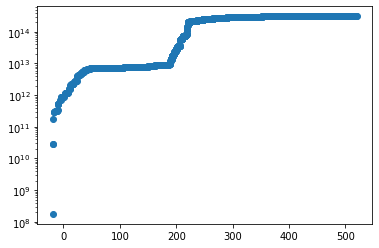

In [63]:
plt.scatter(l, np.cumsum(ovi*dl))
#plt.xscale('log')
plt.yscale('log')
#plt.xlim(1, 500)
#plt.ylim(1e10, 1e16)
plt.show()

In [ ]:
def plot_sightline_data(ray_id):
    plot_data = h5.File('../../data/ray_files/ray_P0_3195_%i.h5'%(ray_id), 'r')

    # see all of the available arrays in the file
    # naming convention: O_p5_number_density = O VI number density

    # Position along the ray (along the y-axis). 0 = cluster center
    l = plot_data['l'].value
    temperature = plot_data['temperature'].value
    density     = plot_data['density'].value
    metallicity = plot_data['metallicity'].value
    vlos        = plot_data['velocity_los'].value
    # size of cell along sightline
    # need this to convert from ion number density to column density
    dl = plot_data['dl'].value
    
    # O VI and H I column densities
    ocol = dl * plot_data['O_p5_number_density'].value
    hcol = dl * plot_data['H_number_density'].value

    field_list = [temperature, density, metallicity, vlos, np.cumsum(hcol), np.cumsum(ocol)]
    ylim_list  = [(1e4, 1e7), (1e-30, 1e-23), (1e-4, 10), (-250, 250), (1e10, 1e20), (1e10, 1e16)]
    ylabel_list = ['Temperature (K)', 'Density (g cm$^{-3}$)', 'Metallicity ($Z_{\odot}$)', 
                    'LOS Velocity (km/s)', 'H I Column Density (cm$^{-2}$)', 'O VI Column Density (cm$^{-2}$)']
    
    fig, ax = plt.subplots(nrows = len(field_list), ncols = 1 , figsize = (6, len(field_list)*3),
                               sharex=True, sharey=False)
    for i in range(len(field_list)):
        ax[i].scatter(l, field_list[i])
        if i != 3:
            ax[i].set_yscale('log')

In [88]:
def plot_sightline_data(ray_id):
    plot_data = h5.File('../../data/ray_files/ray_P0_3195_%i.h5'%(ray_id), 'r')

    # see all of the available arrays in the file
    # naming convention: O_p5_number_density = O VI number density

    # Position along the ray (along the y-axis). 0 = cluster center
    l = plot_data['l'].value
    temperature = plot_data['temperature'].value
    density     = plot_data['density'].value
    metallicity = plot_data['metallicity'].value
    vlos        = plot_data['velocity_los'].value
    # size of cell along sightline
    # need this to convert from ion number density to column density
    dl = plot_data['dl'].value
    
    # O VI and H I column densities
    ocol = dl * plot_data['O_p5_number_density'].value
    hcol = dl * plot_data['H_number_density'].value

    field_list = [temperature, density, metallicity, vlos, np.cumsum(hcol), np.cumsum(ocol)]
    ylim_list  = [(1e4, 1e7), (1e-30, 1e-23), (1e-4, 10), (-300, 300), (1e10, 1e20), (1e10, 1e16)]
    ylabel_list = ['Temperature (K)', 'Density (g cm$^{-3}$)', 'Metallicity ($Z_{\odot}$)', 
                    'LOS Velocity (km/s)', 'H I Column Density (cm$^{-2}$)', 'O VI Column Density (cm$^{-2}$)']
    
    fig, ax = plt.subplots(nrows = len(field_list), ncols = 1 , figsize = (6, len(field_list)*3),
                               sharex=True, sharey=False)
    for i in range(len(field_list)):
        if i > 3:
            label = 'Cumulative Column Density'
        else:
            label = None
        ax[i].scatter(l, field_list[i], label = label)
        if i != 3:
            ax[i].set_yscale('log')            
        ax[i].set_xlim(0, 500)
        ax[i].set_ylim(ylim_list[i])
        ax[i].set_ylabel(ylabel_list[i])
        
    ax[4].scatter(l, hcol, label = 'Local Column Density')
    ax[5].scatter(l, ocol, label = 'Local Column Density')
    ax[len(field_list)-1].set_xlabel
    ax[0].set_xlabel('Lightray Trajectory (kpc)')
    ax[len(field_list)-1].legend()
    fig.tight_layout()
    plt.show()
    plt.savefig('../../plots/P0_z0.25_sightline_%i_multipanel.png'%(output, ray_id))


/Users/irynabutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/Users/irynabutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':
/Users/irynabutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/irynabutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/irynabutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if sys.path[0] =

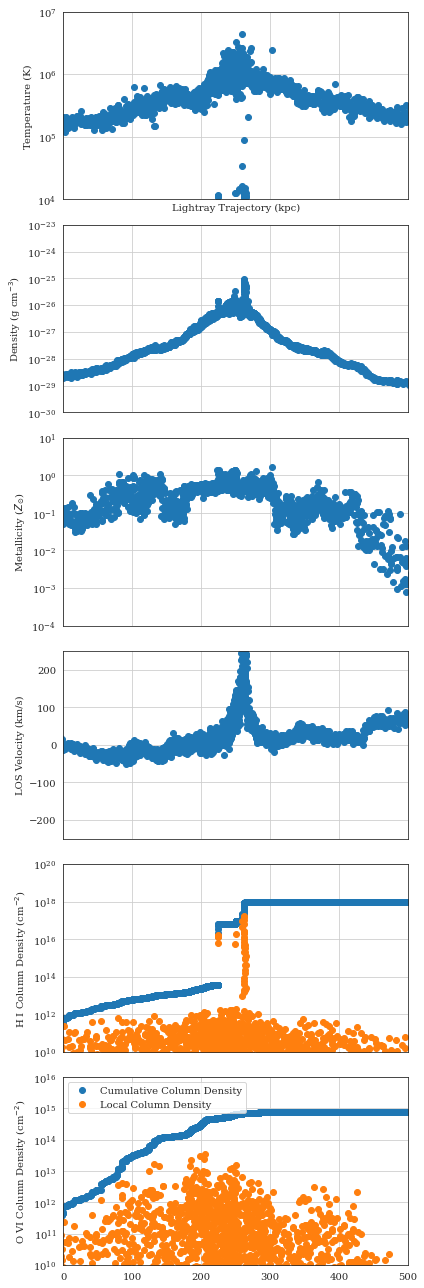

In [89]:
plot_sightline_data(10)

In [102]:
ds = yt.load('/Users/irynabutsky/Work/galaxy/P0/P0.003195')
ad = ds.all_data()


yt : [INFO     ] 2020-04-28 15:07:27,913 Parameters: current_time              = 3.398869692720506e+17 s
yt : [INFO     ] 2020-04-28 15:07:27,914 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-04-28 15:07:27,915 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2020-04-28 15:07:27,916 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2020-04-28 15:07:27,917 Parameters: cosmological_simulation   = 1.0
yt : [INFO     ] 2020-04-28 15:07:27,919 Parameters: current_redshift          = 0.2497948824964893
yt : [INFO     ] 2020-04-28 15:07:27,921 Parameters: omega_lambda              = 0.6914
yt : [INFO     ] 2020-04-28 15:07:27,924 Parameters: omega_matter              = 0.3086
yt : [INFO     ] 2020-04-28 15:07:27,926 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2020-04-28 15:07:27,930 Parameters: hubble_constant           = 0.677583430663222


In [77]:
ray_center = start_pos[10] + 0.5*(end_pos[10] - start_pos[10])
ray_direction = end_pos[10] - start_pos[10]
print(ray_center, ray_direction)


[-0.42299158 -0.30013312  0.13297239] [ 0.00847311 -0.00861534 -0.0031907 ]


In [103]:
c = ds.disk(center, center, (10, 'kpc'), (250, 'kpc'), fields = [('gas', 'density')], data_source = ad)

In [76]:
print(ray_center, ray_direction, width)

[-0.42299158 -0.30013312  0.13297239] [ 0.6779612  -0.68934122 -0.25529845] [0.00749877 0.00049992 0.00049992]


In [71]:
width = np.array([300., 20., 20.]) # kpc
width *= code_unit_conversion
print(width)
image = yt.off_axis_projection(ds, ray_center, ray_direction, width, 
                                   [1200, 80], ('gas', 'temperature'), weight = ('gas', 'density'))


[0.00749877 0.00049992 0.00049992]


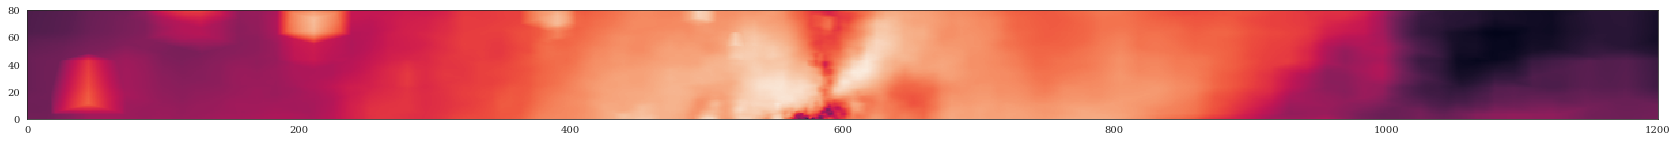

In [80]:
fig, ax = plt.subplots(1, 1, figsize = (30, 2))
ax.pcolormesh(image.T, norm = LogNorm())
ax.set_aspect('equal')

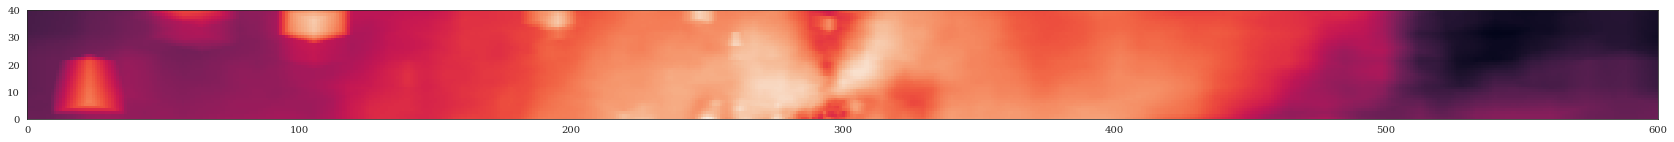

In [58]:
fig, ax = plt.subplots(1, 1, figsize = (30, 2))
ax.pcolormesh(image2.T, norm = LogNorm())
ax.set_aspect('equal')

yt : [INFO     ] 2020-04-28 15:44:56,005 xlim = -0.006249 0.006249
yt : [INFO     ] 2020-04-28 15:44:56,006 ylim = -0.000250 0.000250
yt : [INFO     ] 2020-04-28 15:44:56,007 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



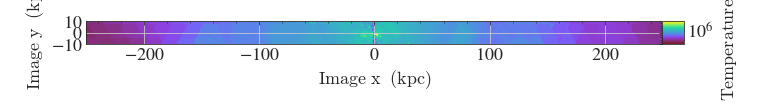

In [21]:
s = yt.OffAxisSlicePlot(ds, [1, 1, 1], ('gas', 'temperature'), center = gcenter, width = ((300, 'kpc'), (20, 'kpc')))
s.show()

In [167]:
import palettable
def get_cmap(field):
    if field =='density':
        cmap = palettable.cmocean.sequential.Tempo_20.mpl_colormap
    elif field == 'pressure':
        cmap = 'magma'
    elif field == 'temperature':
        cmap = palettable.scientific.sequential.LaJolla_20_r.mpl_colormap
    elif field == 'cr_eta':
        cmap = palettable.scientific.sequential.Tokyo_20.mpl_colormap
    elif field == 'cr_pressure':
        cmap = palettable.scientific.sequential.Turku_20.mpl_colormap
    elif field == 'velocity_magnitude':
        cmap = palettable.scientific.diverging.Vik_20.mpl_colormap
    elif field == 'magnetic_field_strength':
        cmap = palettable.scientific.sequential.LaPaz_20.mpl_colormap
    elif field == 'H_p0_number_density':
        cmap = 'purple_mm'
    elif field == 'O_p5_number_density':
        cmap = 'dusk'
    elif field == 'metallicity':
        cmap = 'gist_earth'
    else:
        cmap = 'viridis'
        print(field, ' not mapped')
    return cmap

/Users/irynabutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  del sys.path[0]


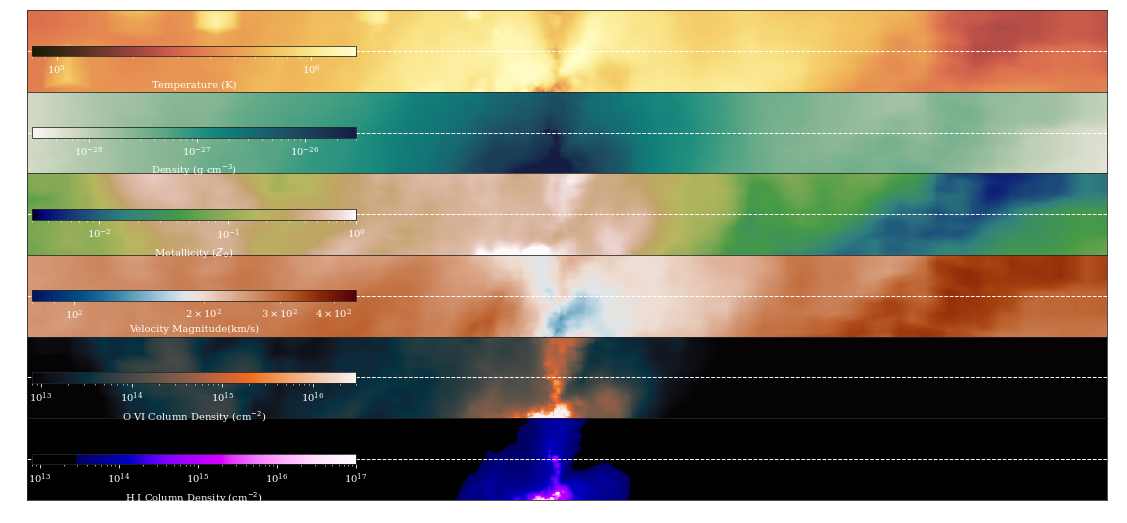

In [173]:
ray_id = 10
f = h5.File('../../data/ray_files/ray_image_data_P0_3195_%i.h5'%ray_id, 'r')
params = {"xtick.color" : "white", 
          "ytick.color" : "white"} 
plt.rcParams.update(params)
field_list = ['temperature', 'density', 'metallicity', 'velocity_magnitude', 'O_p5_number_density', 'H_p0_number_density']
zlim_list  = [(8e4, 1.5e6), (3e-29, 3e-26), (3e-3, 1), (80, 450), (8e12, 3e16), (8e12, 1e17)]
ylabel_list = ['Temperature (K)', 'Density (g cm$^{-3}$)', 'Metallicity ($Z_{\odot}$)', 
                    'Velocity Magnitude(km/s)', 'O VI Column Density (cm$^{-2}$)', 'H I Column Density (cm$^{-2}$)']

fig, ax = plt.subplots(nrows = 6, ncols =1, figsize = (15, 6.8))
for i, field in enumerate(field_list):
    image = f[field].value
    if field == 'metallicity':
        image *= 77.22007722007721  # converting from code units to zsun
    elif field == 'velocity_magnitude':
        image /= 1e5 #converting from cm/s to km/s
    im = ax[i].pcolormesh(image.T, norm = LogNorm(), cmap = get_cmap(field),
                          vmin = zlim_list[i][0], vmax = zlim_list[i][1])
    ax[i].axhline(40, linewidth = 1, color = 'white', linestyle = 'dashed')
    cbax = inset_axes(ax[i], width = "30%", height = "13%", loc = 6)
    cbar = fig.colorbar(im, cax=cbax, orientation = 'horizontal')
    cbar.set_label(ylabel_list[i], color = 'white')
#    cbar = plt.colorbar(im, ax = ax[i], label = ylabel_list[i], pad = 0)
    
#    if i < len(field_list) -1:
#        ax[i].set_xticks([])
#    ax[i].set_yticks([])
    

#ax[-1].set_xlabel('Lightray Trajectory')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.savefig('../../plots/sightline/ray_P0_3195_%i.png'%ray_id, dpi = 300)

In [15]:
gcenter = YTArray([-1.693207e+04, -1.201068e+04, 5.303337e+03], 'kpc')


In [108]:
f['velocity_magnitude'].value

/Users/irynabutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """Entry point for launching an IPython kernel.


array([[25181900.81207355, 25180849.16551462, 25179797.05198088, ...,
        25236068.02669496, 25233300.68192563, 25229792.36008735],
       [25181049.34246323, 25179378.42447308, 25177709.89923671, ...,
        25251212.97293631, 25248730.39661709, 25246251.13552249],
       [25178594.38470634, 25176934.17967522, 25175276.33931275, ...,
        25266129.5785286 , 25263655.81335916, 25261537.60683057],
       ...,
       [28349062.60556733, 28347936.24747214, 28346811.25236311, ...,
        33864596.18858167, 33856530.06597046, 33848424.15251491],
       [28317938.64017791, 28316821.25885342, 28315705.24169002, ...,
        33934225.84885916, 33926243.85303161, 33918222.04538904],
       [28286254.83198053, 28285146.93382301, 28284040.40039866, ...,
        34005406.84980758, 33997514.76210134, 33989582.8702976 ]])

In [110]:
v = YTArray([25181900.81207355], 'cm/s')
v.in_units('km/s')

YTArray([251.81900812]) km/s

In [136]:
ad = ds.all_data()
test1 = ad[('gas', 'metallicity')][0]

In [137]:
test1


0.0 code_metallicity

In [131]:
ad = ds.all_data()


In [138]:
m = ad[('gas', 'metallicity')]

In [139]:
m

YTArray([0., 0., 0., ..., 0., 0., 0.]) code_metallicity

In [140]:
max(m)

0.05626820051235828 code_metallicity

In [141]:
max(m.in_units('Zsun'))

4.3450347885990945 Zsun

In [163]:
4.3450347885990945 / 0.05626820051235828

77.22007722007721